# مشروع بناء نموذج تنبؤي لأمانة منطقة الجوف 
## الرخص التجارية
*الفكره*
تطوير نموذج تنبؤ زمني لتحليل بيانات إصدار الرخص التجارية حسب التوزيع الشهري والأسبوعي، بهدف استكشاف الأنماط الموسمية وتوقّع فترات الذروة أو الركود في الطلب على الرخص. سلسلة المهام الفرعية تتضمن: تجهيز البيانات، التحليل ، بناء النموذج، تفسير ونشر النتائج، وتوثيق الفوائد والاستنتاجات النهائية.

## 0. تنزيل المكتبات و البيانات

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv("Commercial license data.csv")
df.head()

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب
0,أمانة منطقة الجوف,بلدية دومة الجندل,تعديل رخصة تجارية,8/27/03,12/11/2025,منتهى,التدوير وإعادة استخدام النفايات البلدية,الأنشطة الأخرى,383005,12/22/2024
1,أمانة منطقة الجوف,بلدية طبرجل,إصدار رخصة تجارية,9/14/24,09/03/2025,منتهى,الصالونات الرجالية,المحلات التجارية,960220,09/14/2024
2,أمانة منطقة الجوف,الحديثة,إصدار رخصة تجارية,6/11/24,06/01/2025,منتهى,البيع بالجملة والتجزئة لقطع الغيار الجديده للس...,المحلات التجارية,453011,05/21/2024
3,أمانة منطقة الجوف,بلدية دومة الجندل,تعديل رخصة تجارية,12/4/16,09/20/2023,منتهى,الصالونات الرجالية,المحلات التجارية,960220,12/09/2024
4,أمانة منطقة الجوف,بلدية وسط سكاكا,نقل ملكية رخصة تجارية,8/14/24,08/04/2025,منتهى,المطاعم مع الخدمة,المطابخ و المطاعم و ما في حكمها,561010,11/06/2024


## 1. تحليل البيانات الأستكشافي

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   الأمانة                    7823 non-null   object
 1   البلدية                    7823 non-null   object
 2   نوع الطلب                  7823 non-null   object
 3   تاريخ اصدار الرخصة ميلادي  7823 non-null   object
 4   تاريخ نهاية الرخصة ميلادي  7823 non-null   object
 5   حالة الطلب                 7823 non-null   object
 6   مسمى نشاط الايزك           7823 non-null   object
 7   اسم النشاط الرئيسي         7823 non-null   object
 8   رمز نشاط الايزك            7823 non-null   int64 
 9   تاريخ الطلب                7823 non-null   object
dtypes: int64(1), object(9)
memory usage: 611.3+ KB


### 1.1 التحقق من القيم المفقودة

In [4]:
for col in df.columns:
    if df[col].isnull().any():
        print(f"Column '{col}' has missing values.")
        print(df[col].isnull().sum(), "missing values")

بعد التحقق من القيم المفقودة في جميع الأعمدة، لم يتم العثور على أي قيم ناقصة في بيانات الرخص التجارية تحتاج الى تعويض وملء. 



### 1.2 تحويل فئات الخصائص إلى نوع تاريخ

In [5]:
df.columns

Index(['الأمانة', 'البلدية', 'نوع الطلب', 'تاريخ اصدار الرخصة ميلادي',
       'تاريخ نهاية الرخصة ميلادي', 'حالة الطلب', 'مسمى نشاط الايزك',
       'اسم النشاط الرئيسي', 'رمز نشاط الايزك', 'تاريخ الطلب'],
      dtype='object')

In [6]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' in col and 'هجري' not in col:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Column '{col}' converted to datetime.")

Column 'تاريخ اصدار الرخصة ميلادي' converted to datetime.
Column 'تاريخ نهاية الرخصة ميلادي' converted to datetime.
Column 'تاريخ الطلب' converted to datetime.


C:\Users\USER\AppData\Local\Temp\ipykernel_5884\848563665.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [7]:
pd.set_option('display.max_columns', None)

In [8]:
df.sample()

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب
6660,أمانة منطقة الجوف,بلدية وسط سكاكا,تعديل رخصة تجارية,2023-09-12,2025-08-21,منتهى,البيع بالتجزئة لأصناف العبايات النسائية والفراء,المحلات التجارية,477122,2024-12-15


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    7823 non-null   object        
 1   البلدية                    7823 non-null   object        
 2   نوع الطلب                  7823 non-null   object        
 3   تاريخ اصدار الرخصة ميلادي  7823 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  7823 non-null   datetime64[ns]
 5   حالة الطلب                 7823 non-null   object        
 6   مسمى نشاط الايزك           7823 non-null   object        
 7   اسم النشاط الرئيسي         7823 non-null   object        
 8   رمز نشاط الايزك            7823 non-null   int64         
 9   تاريخ الطلب                7823 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(6)
memory usage: 611.3+ KB


### 1.3 ماهو مدى البيانات

In [10]:
print(" Minimum date:", df['تاريخ الطلب'].min())
print(" Maximum date:", df['تاريخ الطلب'].max())

 Minimum date: 2024-01-01 00:00:00
 Maximum date: 2024-12-31 00:00:00


In [11]:
print("Minimum date:", df['تاريخ اصدار الرخصة ميلادي'].min())
print("Maximum date:", df['تاريخ اصدار الرخصة ميلادي'].max())

Minimum date: 1984-04-18 00:00:00
Maximum date: 2025-06-25 00:00:00


In [12]:
count = 0
for col in df.columns:
    if 'تاريخ' in col:
        count+=1
print("Number of date columns:", count)

Number of date columns: 3


### 1.4 ماهي القيم داخل الأعمدة

In [13]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        unique_values = df[col].unique()
        print(f"Column '{col}' has {len(unique_values)} unique values.")

Column 'الأمانة' has 1 unique values.
Column 'البلدية' has 13 unique values.
Column 'نوع الطلب' has 8 unique values.
Column 'حالة الطلب' has 2 unique values.
Column 'مسمى نشاط الايزك' has 477 unique values.
Column 'اسم النشاط الرئيسي' has 16 unique values.


In [14]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        values = df[col].value_counts()
        print(f"Column '{col}' value counts:")
        print(values)
        print("\n")


Column 'الأمانة' value counts:
الأمانة
أمانة منطقة الجوف    7823
Name: count, dtype: int64


Column 'البلدية' value counts:
البلدية
بلدية وسط سكاكا            2290
بلدية القريات              2080
بلدية طبرجل                1280
بلدية شمال سكاكا            740
بلدية دومة الجندل           508
بلدية جنوب سكاكا - قارا     338
بلدية صوير                  155
بلدية أبوعجرم               142
الحديثة                     117
بلدية زلوم                   70
بلدية العيساويه              63
بلدية الناصفه                29
أمانة منطقة الجوف            11
Name: count, dtype: int64


Column 'نوع الطلب' value counts:
نوع الطلب
تعديل رخصة تجارية               3970
تجديد رخصة تجارية               1620
إصدار رخصة تجارية                941
الغاء رخصة تجارية                864
الإلغاء الآلي للرخص المنتهية     182
نقل ملكية رخصة تجارية            177
تحديث بيانات رخصة تجارية          68
طلب رخصة قديمة                     1
Name: count, dtype: int64


Column 'حالة الطلب' value counts:
حالة الطلب
منتهى       

In [15]:
df[df['حالة الطلب'] == 'يوجد ملاحظات رقابة لاحقة'].head(7)

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب
1591,أمانة منطقة الجوف,بلدية طبرجل,تعديل رخصة تجارية,2022-05-25,2025-04-22,يوجد ملاحظات رقابة لاحقة,البيع بالتجزئة لمنتجات المخابز والحلويات السكرية,المحلات التجارية,472161,2024-10-23
1635,أمانة منطقة الجوف,بلدية طبرجل,تعديل رخصة تجارية,2016-10-15,2025-07-09,يوجد ملاحظات رقابة لاحقة,المطاعم مع الخدمة,المطابخ و المطاعم و ما في حكمها,561010,2024-11-19
3033,أمانة منطقة الجوف,بلدية طبرجل,تعديل رخصة تجارية,2018-04-20,2027-01-11,يوجد ملاحظات رقابة لاحقة,غسل وكي والتنظيف الجاف لشتى أنواع الملابس بما ...,المحلات التجارية,960110,2024-10-23
3785,أمانة منطقة الجوف,بلدية أبوعجرم,تعديل رخصة تجارية,2017-02-23,2027-10-25,يوجد ملاحظات رقابة لاحقة,تفصيل وخياطة وحياكة الملابس الرجالية العربية ...,المحلات التجارية,141040,2024-12-13
4355,أمانة منطقة الجوف,بلدية طبرجل,تعديل رخصة تجارية,2022-05-23,2025-04-20,يوجد ملاحظات رقابة لاحقة,اصلاح ميكانيكا وكهرباء السيارات,الورش المهنية,452021,2024-11-28
5289,أمانة منطقة الجوف,بلدية أبوعجرم,تعديل رخصة تجارية,2020-11-04,2025-09-10,يوجد ملاحظات رقابة لاحقة,المطاعم مع الخدمة,المطابخ و المطاعم و ما في حكمها,561010,2024-11-05
6800,أمانة منطقة الجوف,بلدية طبرجل,تعديل رخصة تجارية,2022-07-06,2025-06-03,يوجد ملاحظات رقابة لاحقة,إصلاح وصيانة الجرارات الزراعية,الورش المهنية,331221,2024-11-28


### 1.5 حذف العينات المكررة

In [16]:
df[df.duplicated()]

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب
2257,أمانة منطقة الجوف,بلدية طبرجل,إصدار رخصة تجارية,2024-11-28,2025-11-17,منتهى,التموينات,المحلات التجارية,471132,2024-11-28
2544,أمانة منطقة الجوف,بلدية القريات,تجديد رخصة تجارية,2022-01-26,2025-12-14,منتهى,غسل وكي والتنظيف الجاف لشتى أنواع الملابس بما ...,المحلات التجارية,960110,2024-01-15
2621,أمانة منطقة الجوف,بلدية وسط سكاكا,تعديل رخصة تجارية,2023-10-26,2025-10-03,منتهى,اصلاح ماكينات السيارات,الورش المهنية,452011,2024-12-25
2765,أمانة منطقة الجوف,بلدية طبرجل,إصدار رخصة تجارية,2024-04-18,2025-04-07,منتهى,المطاعم مع الخدمة,المطابخ و المطاعم و ما في حكمها,561010,2024-04-18
3018,أمانة منطقة الجوف,بلدية القريات,إصدار رخصة تجارية,2024-08-27,2025-08-17,منتهى,المطاعم مع الخدمة,المطابخ و المطاعم و ما في حكمها,561010,2024-08-27
3403,أمانة منطقة الجوف,بلدية طبرجل,تجديد رخصة تجارية,2019-03-17,2025-01-10,منتهى,تقديم خدمات الدفع لنقاط البيع والمنافذ الإلكتر...,إصدار التراخيص بتأسيس أو تشغيل الصراف الألي,661911,2024-01-02
3605,أمانة منطقة الجوف,بلدية طبرجل,إصدار رخصة تجارية,2024-10-08,2026-09-16,منتهى,صيانة واصلاح وتبديل اطارات السيارات الخفيفة ا...,محلات تغيير الزيوت و الشحوم و غسيل السيارات,452081,2024-10-08
5171,أمانة منطقة الجوف,بلدية شمال سكاكا,إصدار رخصة تجارية,2024-09-10,2025-08-30,منتهى,سيارة متجولة لبيع الأغذية,العربات المتجولة,561060,2024-09-08
5910,أمانة منطقة الجوف,بلدية شمال سكاكا,تجديد رخصة تجارية,2022-08-18,2026-07-05,منتهى,تركيب الابواب والشبابيك وإطارات الابواب الشرش...,المحلات التجارية,433021,2024-11-17
5983,أمانة منطقة الجوف,بلدية وسط سكاكا,تعديل رخصة تجارية,2021-01-31,2025-12-09,منتهى,قص وتفصيل الخيام والأشرعة,المحلات التجارية,139241,2024-10-30


In [17]:
df.drop_duplicates(inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7799 entries, 0 to 7822
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    7799 non-null   object        
 1   البلدية                    7799 non-null   object        
 2   نوع الطلب                  7799 non-null   object        
 3   تاريخ اصدار الرخصة ميلادي  7799 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  7799 non-null   datetime64[ns]
 5   حالة الطلب                 7799 non-null   object        
 6   مسمى نشاط الايزك           7799 non-null   object        
 7   اسم النشاط الرئيسي         7799 non-null   object        
 8   رمز نشاط الايزك            7799 non-null   int64         
 9   تاريخ الطلب                7799 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(6)
memory usage: 670.2+ KB


## 2. تحليل البيانات 

### 2.1 مدة صلاحية الرخصة

In [19]:
df['مدة صلاحية الرخصة'] = df['تاريخ نهاية الرخصة ميلادي'] - df['تاريخ اصدار الرخصة ميلادي']
df['مدة صلاحية الرخصة'] =df['مدة صلاحية الرخصة'].dt.days / 30 / 12 
df['مدة صلاحية الرخصة'] = df['مدة صلاحية الرخصة'].round()

df['مدة صلاحية الرخصة'].unique()


array([23.,  1.,  7.,  2.,  9.,  8.,  3., 10.,  5., 18., 13., 32.,  6.,
       31.,  4., 16., 12., 11., 35., 15., 20., 17., 22., 14., 27., 30.,
       19., 25., 28., 21., 26., 33., 41., 40., 24., 29., 39.,  0., 34.,
       37., 42., 38.])

In [20]:
print("Minimum renewal period:", df['مدة صلاحية الرخصة'].min(), "years")
print("Maximum renewal period:", df['مدة صلاحية الرخصة'].max(), "years")

df['مدة صلاحية الرخصة'].describe()

Minimum renewal period: 0.0 years
Maximum renewal period: 42.0 years


count    7799.000000
mean        4.704193
std         4.295936
min         0.000000
25%         1.000000
50%         3.000000
75%         7.000000
max        42.000000
Name: مدة صلاحية الرخصة, dtype: float64

In [21]:
print('number of linceses has validity more than 10 years:', df[df['مدة صلاحية الرخصة'] > 10].shape[0])

number of linceses has validity more than 10 years: 523


Text(0.5, 0, 'Validity Period (Years)')

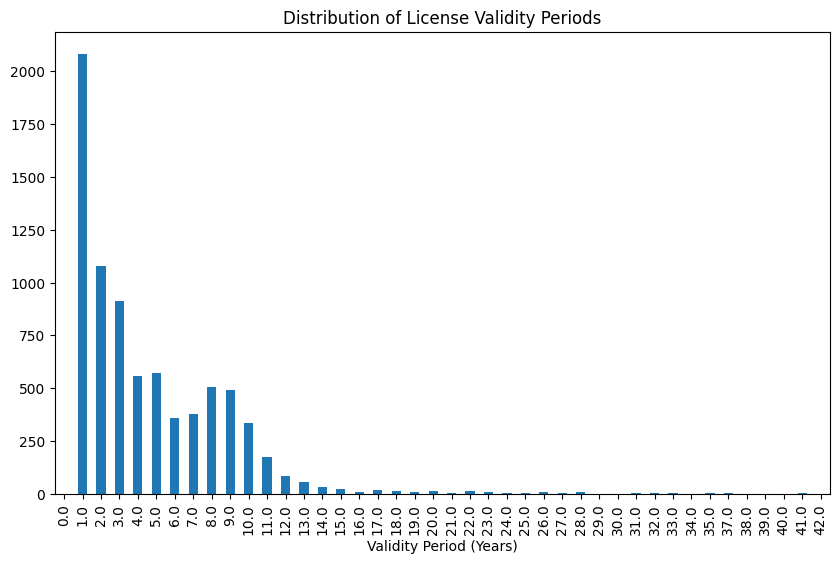

In [22]:

plt.figure(figsize=(10, 6)) 
df['مدة صلاحية الرخصة'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of License Validity Periods')
plt.xlabel('Validity Period (Years)')

#### 2.1.1 انشاء عمود فئة صلاحية الرخصة

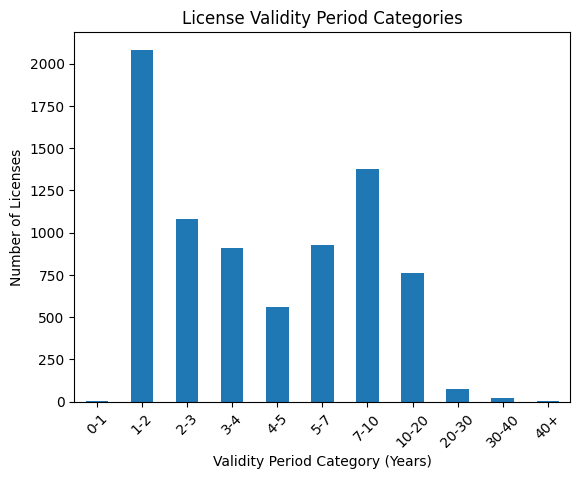

In [23]:
df['فئة مدة صلاحية الرخصة'] = pd.cut(df['مدة صلاحية الرخصة'],
                                     bins=[0, 1, 2, 3, 4, 5, 7, 10, 20, 30, 40, float('inf')],
                                        labels=['0-1', '1-2', '2-3', '3-4', '4-5', '5-7', '7-10', '10-20', '20-30', '30-40', '40+'],
                                            right=False)
df['فئة مدة صلاحية الرخصة'].value_counts().sort_index().plot(kind='bar')
plt.title('License Validity Period Categories')
plt.xlabel('Validity Period Category (Years)')
plt.ylabel('Number of Licenses')
plt.xticks(rotation=45)
plt.show()
                                    

In [24]:
df['فئة مدة صلاحية الرخصة'] = df['فئة مدة صلاحية الرخصة'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7799 entries, 0 to 7822
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    7799 non-null   object        
 1   البلدية                    7799 non-null   object        
 2   نوع الطلب                  7799 non-null   object        
 3   تاريخ اصدار الرخصة ميلادي  7799 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  7799 non-null   datetime64[ns]
 5   حالة الطلب                 7799 non-null   object        
 6   مسمى نشاط الايزك           7799 non-null   object        
 7   اسم النشاط الرئيسي         7799 non-null   object        
 8   رمز نشاط الايزك            7799 non-null   int64         
 9   تاريخ الطلب                7799 non-null   datetime64[ns]
 10  مدة صلاحية الرخصة          7799 non-null   float64       
 11  فئة مدة صلاحية الرخصة      7799 non-null   object        
dtypes: datetime

### 2.2 تحليل تنوع القيم في الخصائص

In [25]:
df.columns

Index(['الأمانة', 'البلدية', 'نوع الطلب', 'تاريخ اصدار الرخصة ميلادي',
       'تاريخ نهاية الرخصة ميلادي', 'حالة الطلب', 'مسمى نشاط الايزك',
       'اسم النشاط الرئيسي', 'رمز نشاط الايزك', 'تاريخ الطلب',
       'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

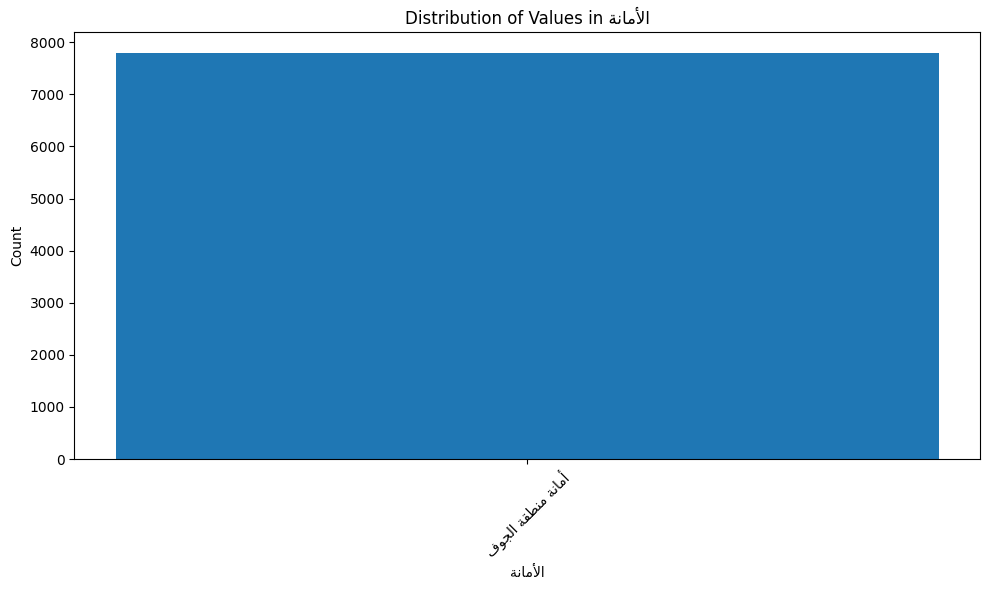

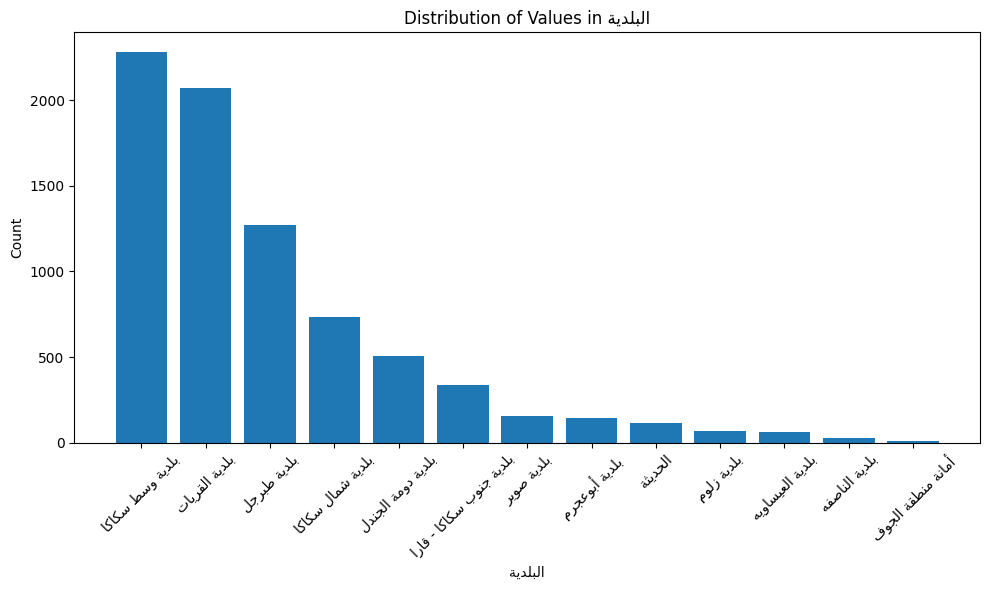

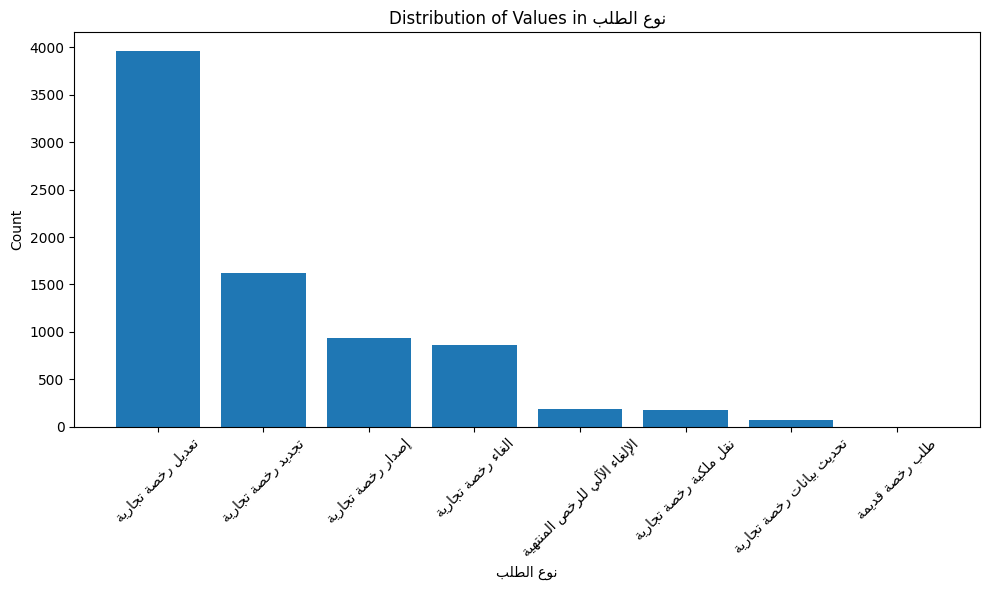

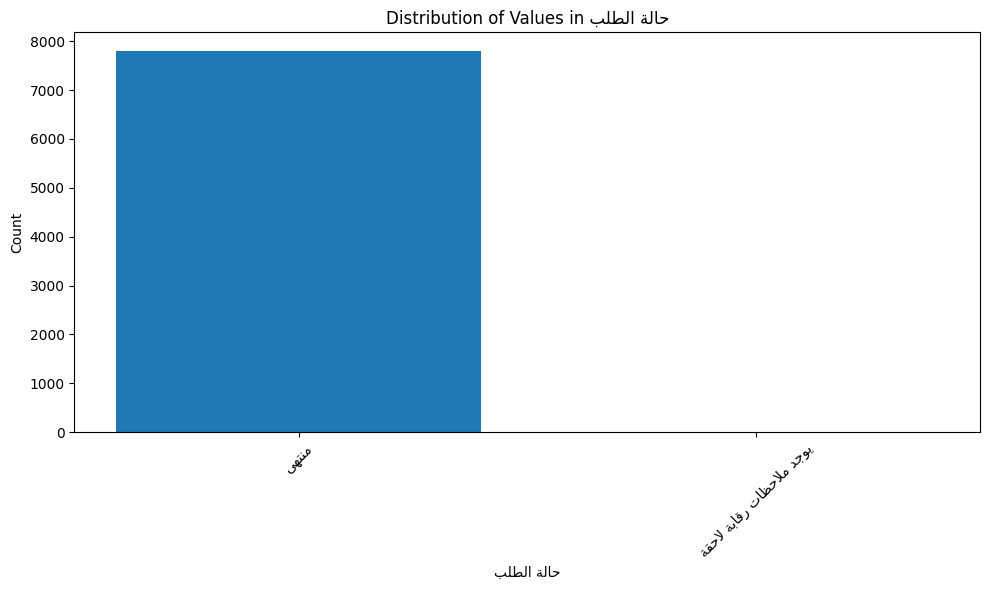

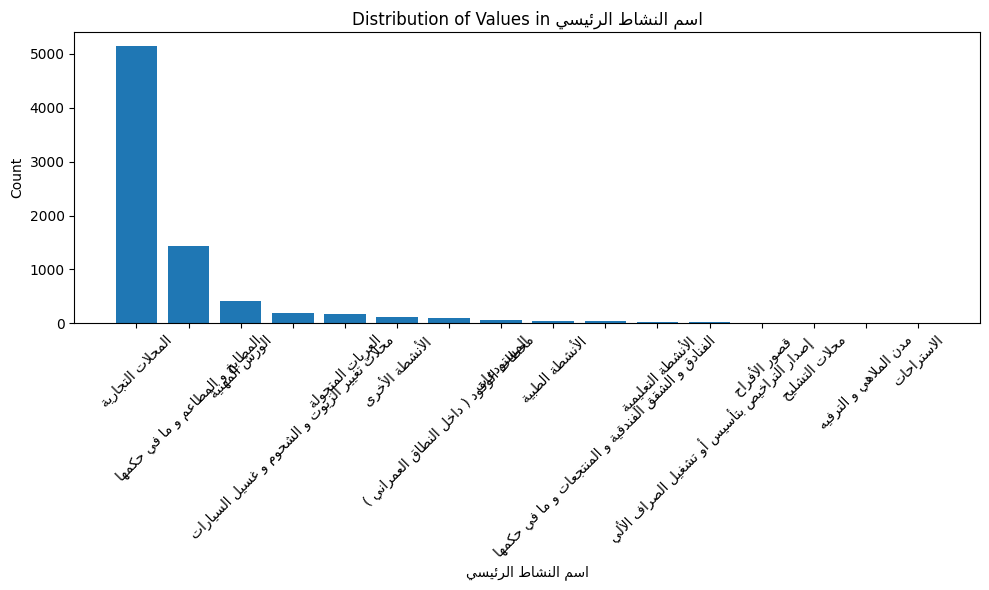

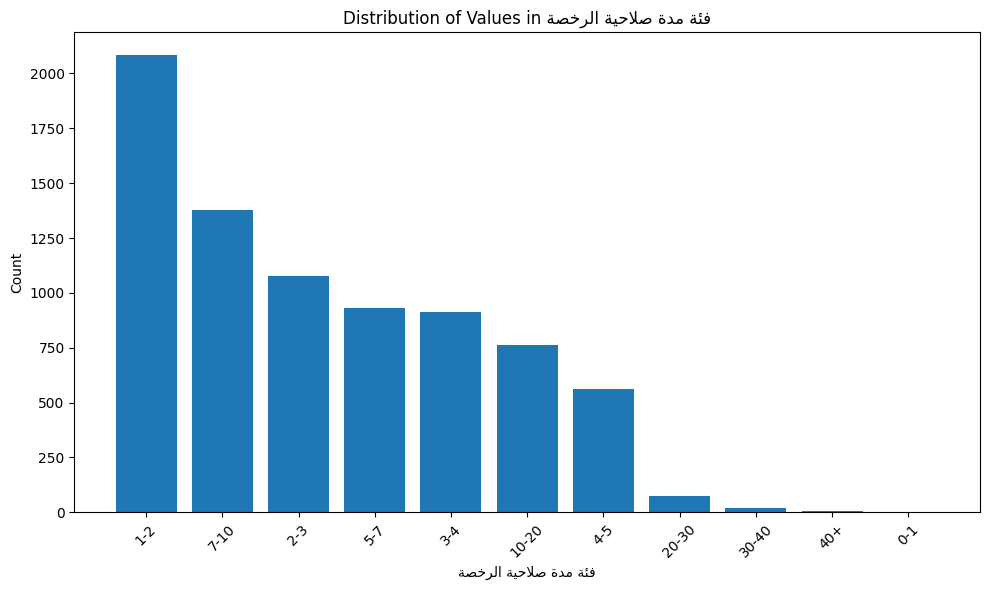

In [26]:
for col in df.columns:
    if df[col].dtype == 'object' and 'تاريخ' not in col:
        value_counts = df[col].value_counts()
        
        if len(value_counts) < 20:
            reshaped_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in value_counts.index]
            
            plt.figure(figsize=(10, 6))
            plt.bar(reshaped_labels, value_counts.values)
            
            reshaped_title = get_display(arabic_reshaper.reshape(col))
            plt.title(f'Distribution of Values in {reshaped_title}')
            plt.xlabel(reshaped_title)
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


In [27]:
df.columns

Index(['الأمانة', 'البلدية', 'نوع الطلب', 'تاريخ اصدار الرخصة ميلادي',
       'تاريخ نهاية الرخصة ميلادي', 'حالة الطلب', 'مسمى نشاط الايزك',
       'اسم النشاط الرئيسي', 'رمز نشاط الايزك', 'تاريخ الطلب',
       'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

### 2.3 مصفوفه الارتباط

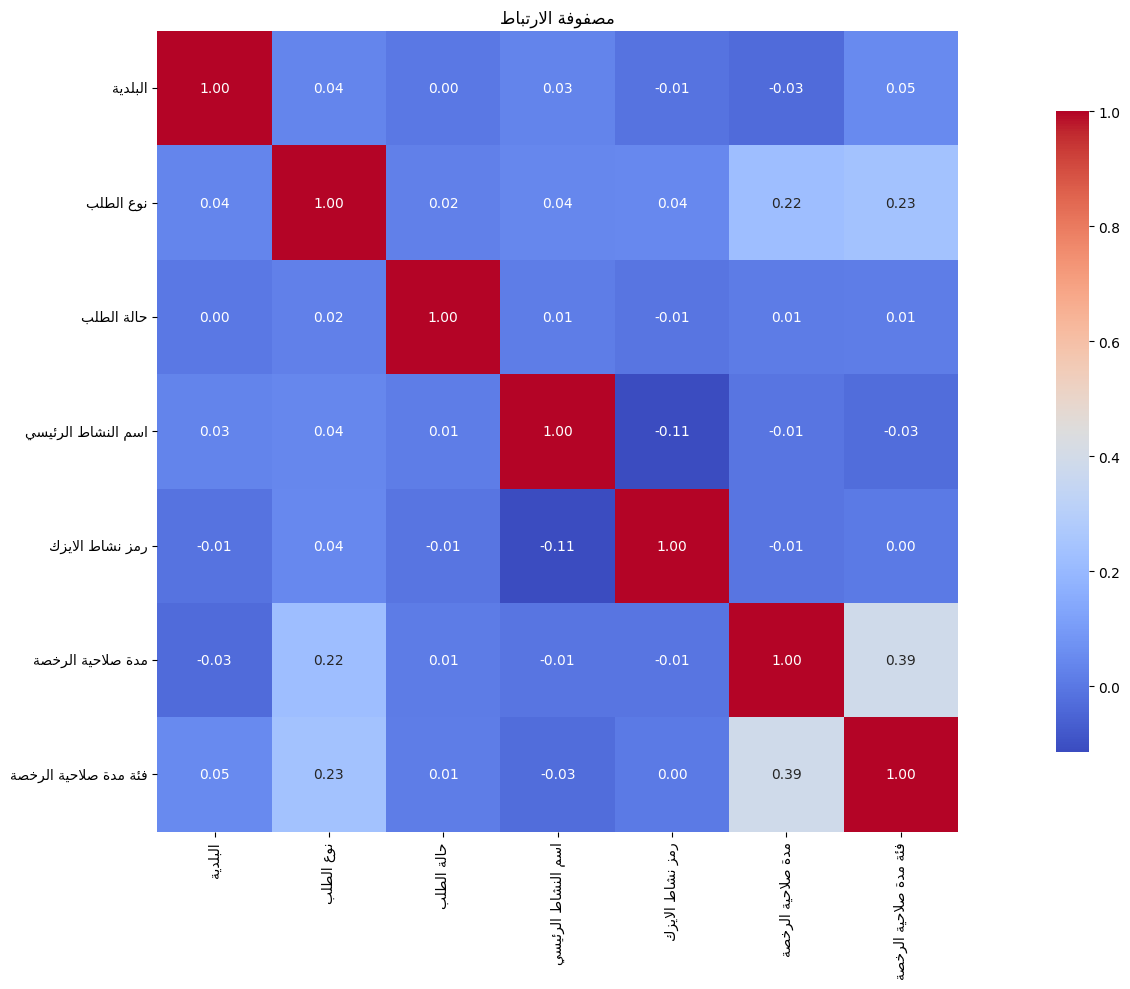

In [28]:
data = df.copy()
for col in data.columns:
    if data[col].dtype == 'object' and 'تاريخ' not in col:
        if len(data[col].unique()) < 20:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))

corr_matrix = data.corr(numeric_only=True)

corr_matrix = corr_matrix.iloc[1:, 1:]

reshaped_labels = [get_display(arabic_reshaper.reshape(str(label))) for label in corr_matrix.columns]
corr_matrix.columns = reshaped_labels
corr_matrix.index = reshaped_labels

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title(get_display(arabic_reshaper.reshape('مصفوفة الارتباط'))) 
plt.tight_layout()
plt.show()


In [29]:
df.sample()

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة
1951,أمانة منطقة الجوف,بلدية القريات,تعديل رخصة تجارية,2024-11-13,2025-11-02,منتهى,الصالونات الرجالية,المحلات التجارية,960220,2024-11-21,1.0,1-2


In [30]:
data.sample()

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة
3568,0,12,0,2024-11-28,2025-11-17,0,البقالات,7,471131,2024-11-27,1.0,1


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7799 entries, 0 to 7822
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   الأمانة                    7799 non-null   int64         
 1   البلدية                    7799 non-null   int64         
 2   نوع الطلب                  7799 non-null   int64         
 3   تاريخ اصدار الرخصة ميلادي  7799 non-null   datetime64[ns]
 4   تاريخ نهاية الرخصة ميلادي  7799 non-null   datetime64[ns]
 5   حالة الطلب                 7799 non-null   int64         
 6   مسمى نشاط الايزك           7799 non-null   object        
 7   اسم النشاط الرئيسي         7799 non-null   int64         
 8   رمز نشاط الايزك            7799 non-null   int64         
 9   تاريخ الطلب                7799 non-null   datetime64[ns]
 10  مدة صلاحية الرخصة          7799 non-null   float64       
 11  فئة مدة صلاحية الرخصة      7799 non-null   int64         
dtypes: datetime

### 2.4 تحليل الارتباط التاريخي

In [32]:
for col in df.columns:
    if 'تاريخ' in col:
        print(col)

تاريخ اصدار الرخصة ميلادي
تاريخ نهاية الرخصة ميلادي
تاريخ الطلب


In [33]:
for col in df.columns:
    if 'تاريخ' in col and 'هجري' not in col:
        print(col)

تاريخ اصدار الرخصة ميلادي
تاريخ نهاية الرخصة ميلادي
تاريخ الطلب


In [34]:
df.columns

Index(['الأمانة', 'البلدية', 'نوع الطلب', 'تاريخ اصدار الرخصة ميلادي',
       'تاريخ نهاية الرخصة ميلادي', 'حالة الطلب', 'مسمى نشاط الايزك',
       'اسم النشاط الرئيسي', 'رمز نشاط الايزك', 'تاريخ الطلب',
       'مدة صلاحية الرخصة', 'فئة مدة صلاحية الرخصة'],
      dtype='object')

In [35]:
collection = ['البلدية','نوع الطلب','اسم النشاط الرئيسي','فئة مدة صلاحية الرخصة']
for col in collection:
    pass
    #print(df[col].value_counts())
    #print(f'{col}: {df[col].dtype}')


In [36]:
weekday_map = {
    'Sunday': 'الأحد',
    'Monday': 'الإثنين',
    'Tuesday': 'الثلاثاء',
    'Wednesday': 'الأربعاء',
    'Thursday': 'الخميس',
    'Friday': 'الجمعة',
    'Saturday': 'السبت'
}

In [37]:
df['سنة الطلب'] = df['تاريخ الطلب'].dt.year
df['شهر الطلب'] = df['تاريخ الطلب'].dt.month
df['أسبوع الطلب'] = df['تاريخ الطلب'].dt.isocalendar().week
df['يوم الأسبوع'] = df['تاريخ الطلب'].dt.day_name().map(weekday_map)
df['يوم الطلب'] = df['تاريخ الطلب'].dt.day

In [38]:
df.sample()

,الأمانة,البلدية,نوع الطلب,تاريخ اصدار الرخصة ميلادي,تاريخ نهاية الرخصة ميلادي,حالة الطلب,مسمى نشاط الايزك,اسم النشاط الرئيسي,رمز نشاط الايزك,تاريخ الطلب,مدة صلاحية الرخصة,فئة مدة صلاحية الرخصة,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الأسبوع,يوم الطلب
6255,أمانة منطقة الجوف,بلدية دومة الجندل,تجديد رخصة تجارية,2023-02-19,2025-01-28,منتهى,غسيل وتشحيم السيارات,محلات تغيير الزيوت و الشحوم و غسيل السيارات,452051,2024-04-24,2.0,2-3,2024,4,17,الأربعاء,24


In [39]:
columns_needed = collection + ['تاريخ الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب', 'يوم الأسبوع']
dataframe = df[columns_needed]
dataframe.head()

,البلدية,نوع الطلب,اسم النشاط الرئيسي,فئة مدة صلاحية الرخصة,تاريخ الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع
0,بلدية دومة الجندل,تعديل رخصة تجارية,الأنشطة الأخرى,20-30,2024-12-22,2024,12,51,22,الأحد
1,بلدية طبرجل,إصدار رخصة تجارية,المحلات التجارية,1-2,2024-09-14,2024,9,37,14,السبت
2,الحديثة,إصدار رخصة تجارية,المحلات التجارية,1-2,2024-05-21,2024,5,21,21,الثلاثاء
3,بلدية دومة الجندل,تعديل رخصة تجارية,المحلات التجارية,7-10,2024-12-09,2024,12,50,9,الإثنين
4,بلدية وسط سكاكا,نقل ملكية رخصة تجارية,المطابخ و المطاعم و ما في حكمها,1-2,2024-11-06,2024,11,45,6,الأربعاء


In [40]:
def reshape_arabic(text):
    return get_display(arabic_reshaper.reshape(text))

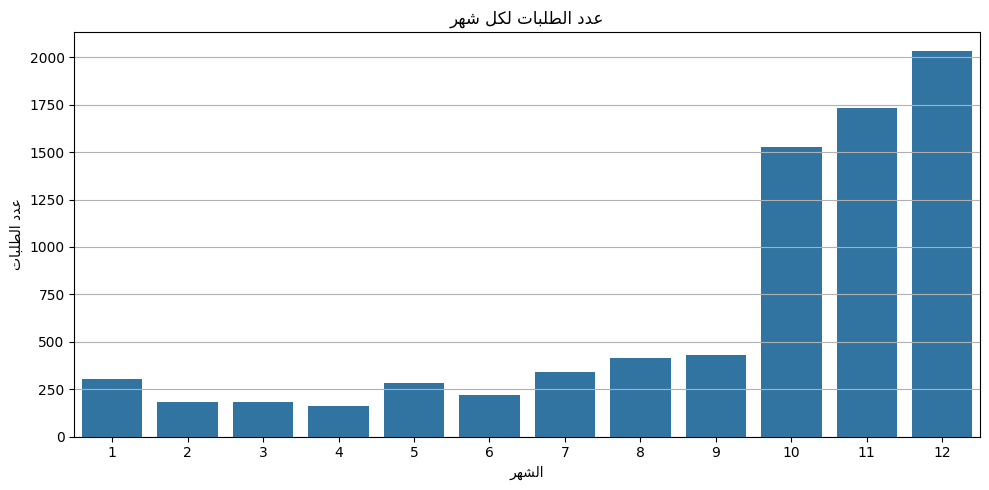

In [41]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='شهر الطلب', order=sorted(dataframe['شهر الطلب'].unique()))
plt.title(reshape_arabic('عدد الطلبات لكل شهر'))
plt.xlabel(reshape_arabic('الشهر'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

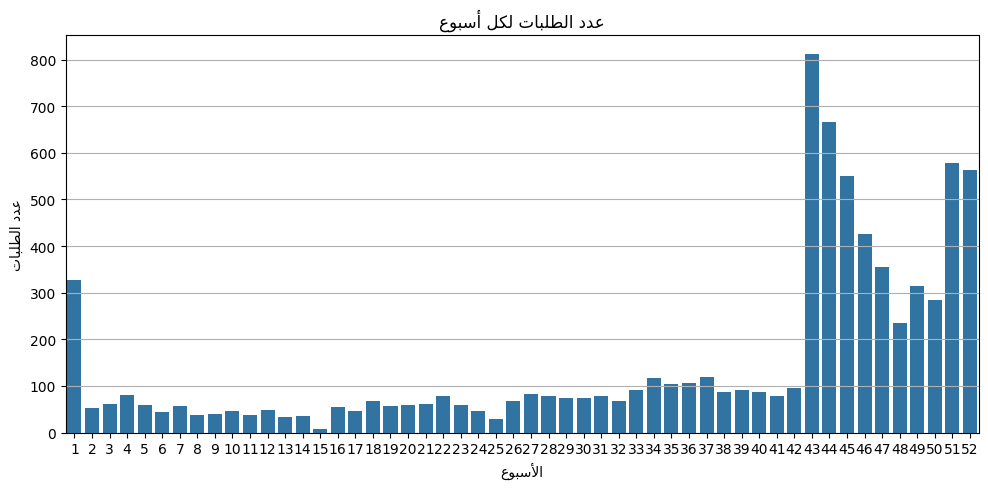

In [42]:
plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='أسبوع الطلب', order=sorted(dataframe['أسبوع الطلب'].unique()))
plt.title(reshape_arabic('عدد الطلبات لكل أسبوع'))
plt.xlabel(reshape_arabic('الأسبوع'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [43]:
dataframe.columns

Index(['البلدية', 'نوع الطلب', 'اسم النشاط الرئيسي', 'فئة مدة صلاحية الرخصة',
       'تاريخ الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب',
       'يوم الأسبوع'],
      dtype='object')

C:\Users\USER\AppData\Local\Temp\ipykernel_5884\101200610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['يوم الأسبوع (عرض)'] = dataframe['يوم الأسبوع'].apply(reshape_arabic)


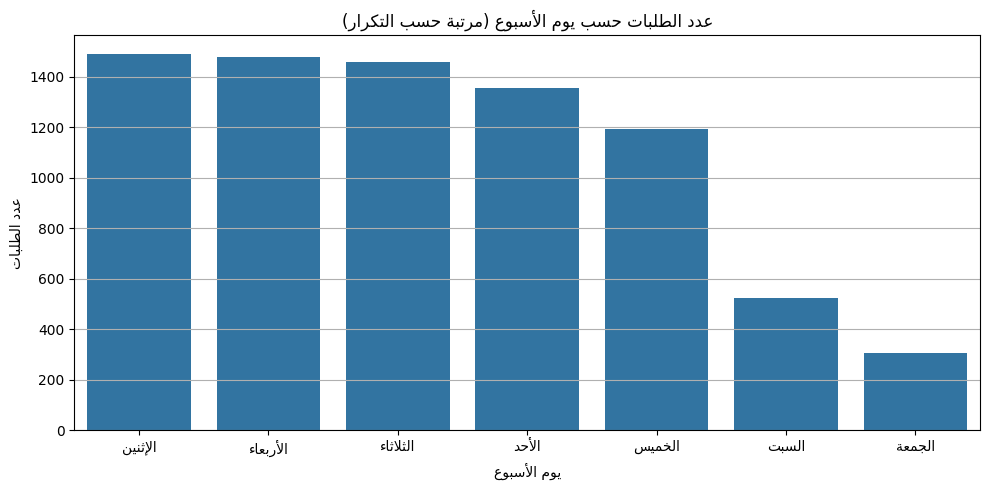

In [44]:
weekday_order = dataframe['يوم الأسبوع'].value_counts().index.tolist()
reshaped_order = [reshape_arabic(day) for day in weekday_order]

dataframe['يوم الأسبوع (عرض)'] = dataframe['يوم الأسبوع'].apply(reshape_arabic)

plt.figure(figsize=(10, 5))
sns.countplot(data=dataframe, x='يوم الأسبوع (عرض)', order=reshaped_order)
plt.title(reshape_arabic('عدد الطلبات حسب يوم الأسبوع (مرتبة حسب التكرار)'))
plt.xlabel(reshape_arabic('يوم الأسبوع'))
plt.ylabel(reshape_arabic('عدد الطلبات'))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [45]:
dataframe.columns

Index(['البلدية', 'نوع الطلب', 'اسم النشاط الرئيسي', 'فئة مدة صلاحية الرخصة',
       'تاريخ الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب',
       'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\

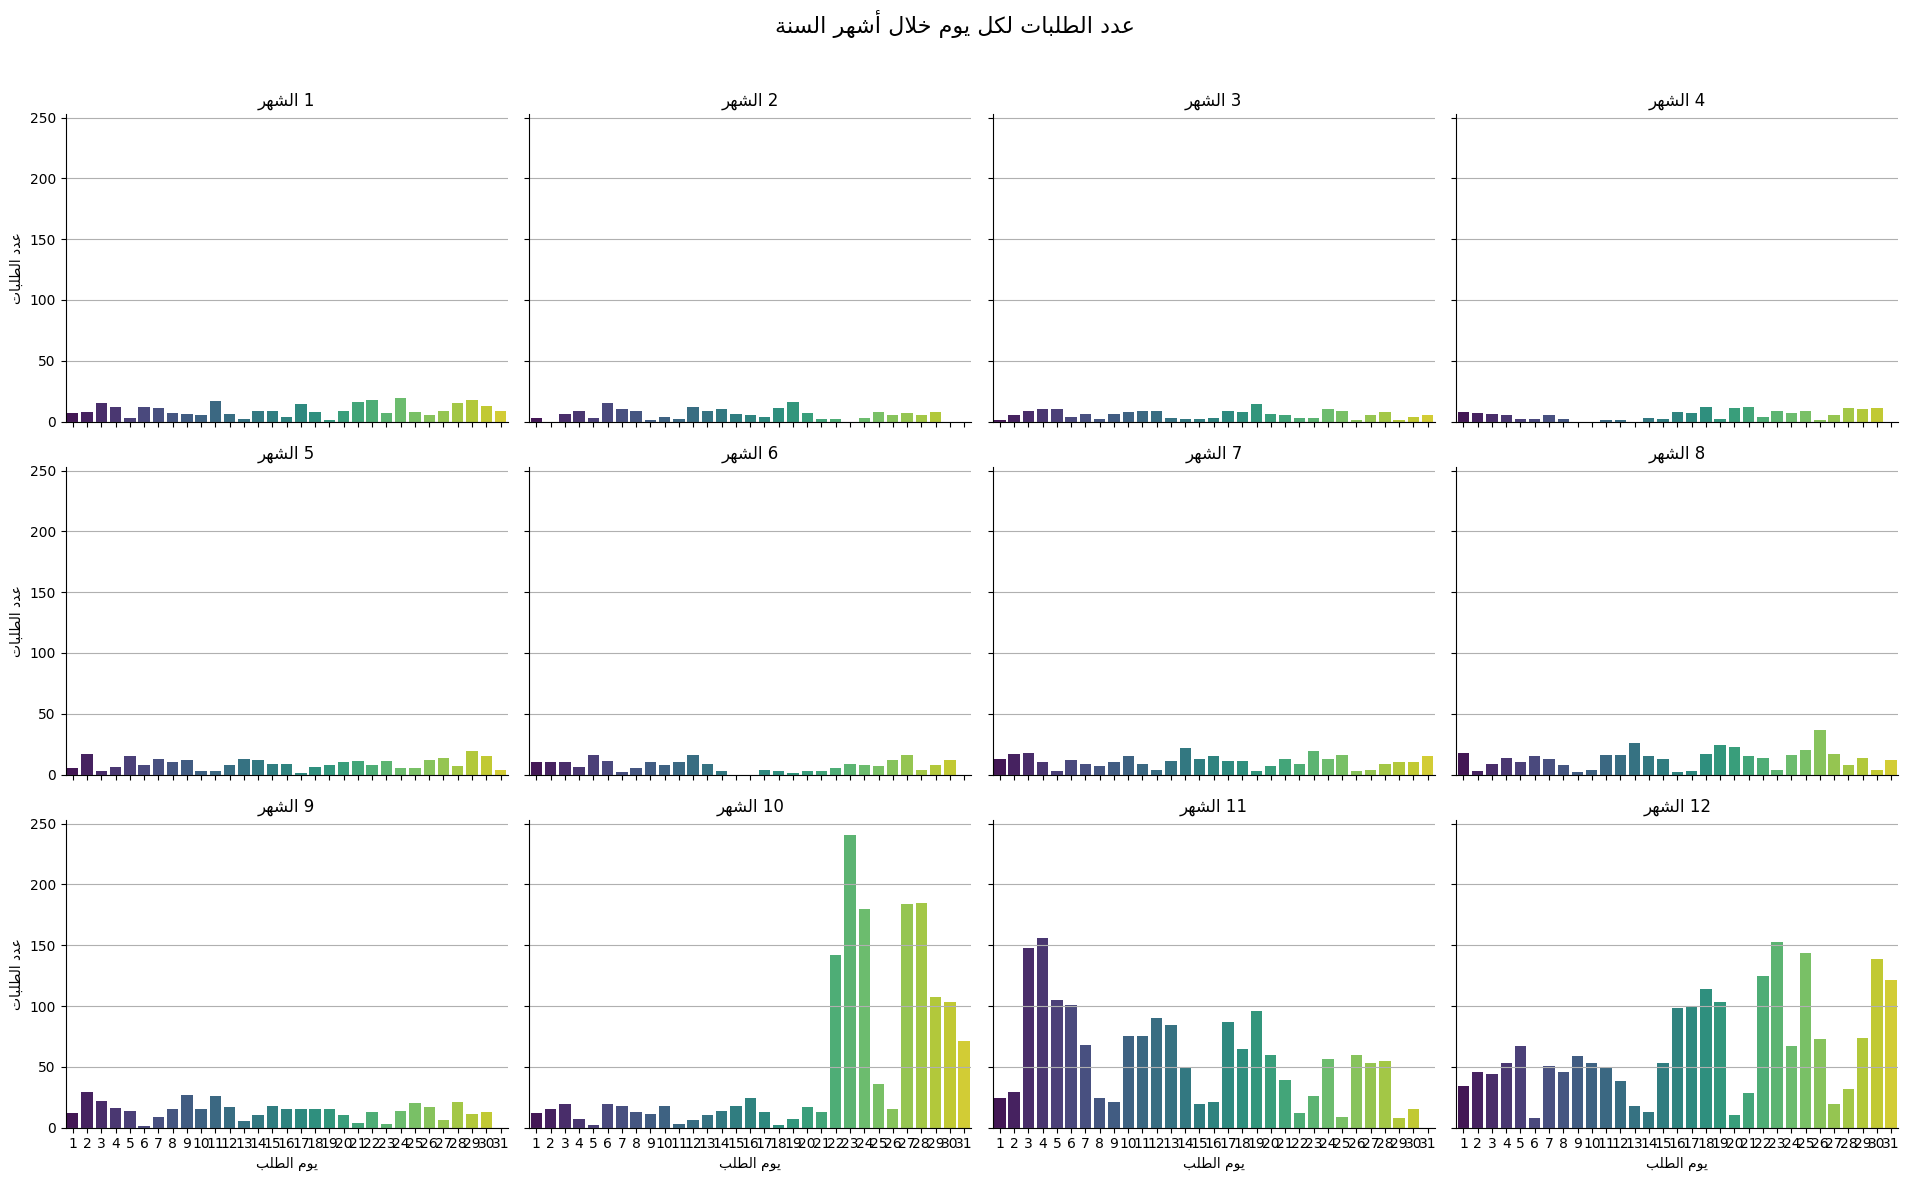

In [46]:
g = sns.FacetGrid(dataframe, col='شهر الطلب', col_wrap=4, height=4, aspect=1.2)
g.map(sns.countplot, 'يوم الطلب', order=range(1, 32), palette='viridis')

for ax in g.axes.flat:
    ax.set_title(reshape_arabic('الشهر') + f" {int(ax.get_title().split('=')[1])}")
    ax.set_xlabel(reshape_arabic('يوم الطلب'))
    ax.set_ylabel(reshape_arabic('عدد الطلبات'))
    ax.grid(axis='y')

plt.suptitle(reshape_arabic('عدد الطلبات لكل يوم خلال أشهر السنة'), fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # لتجنب تغطية العنوان الرئيسي
plt.show()

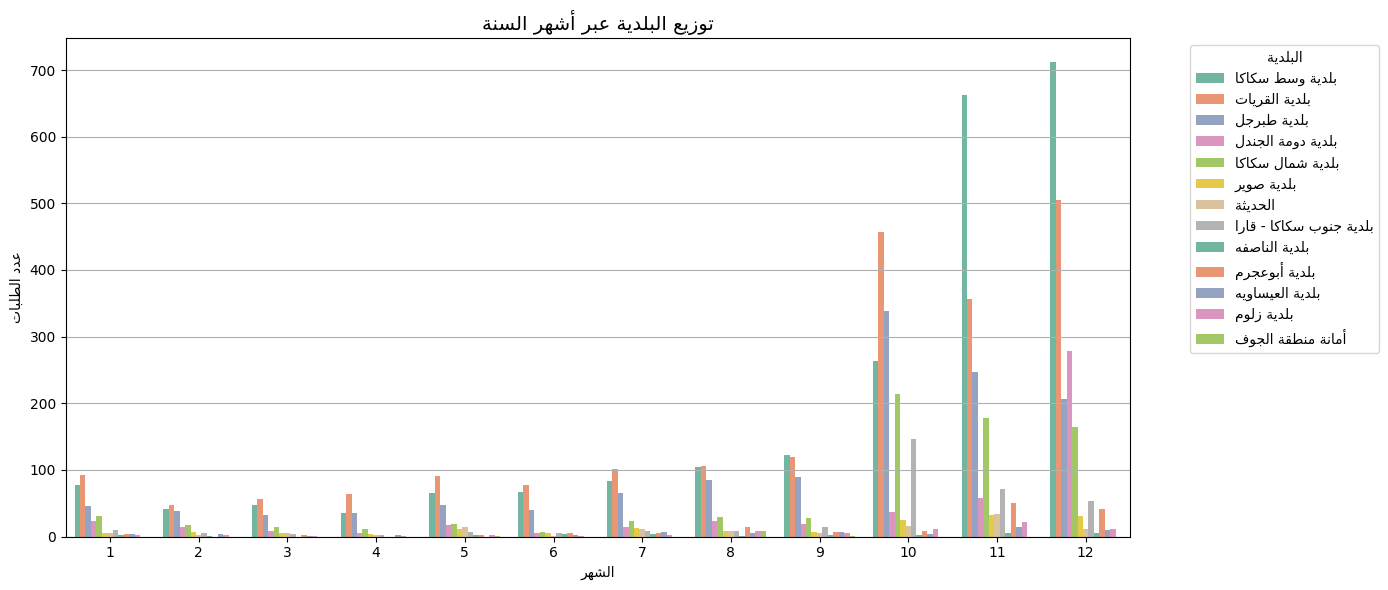

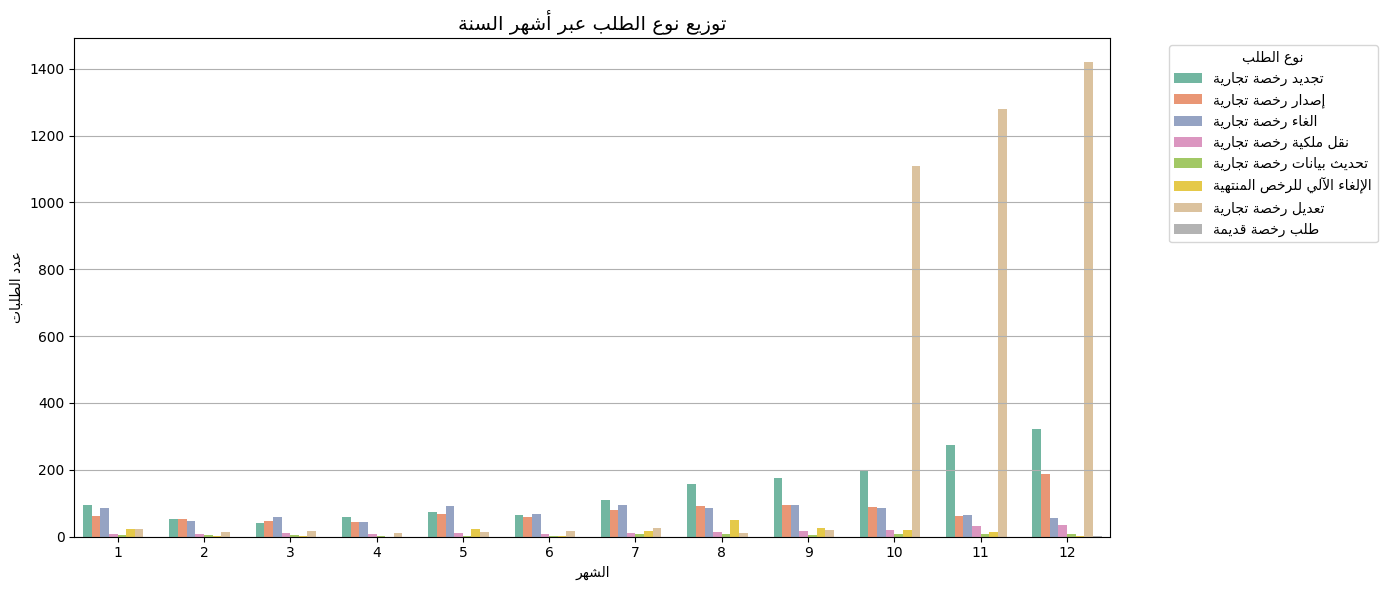

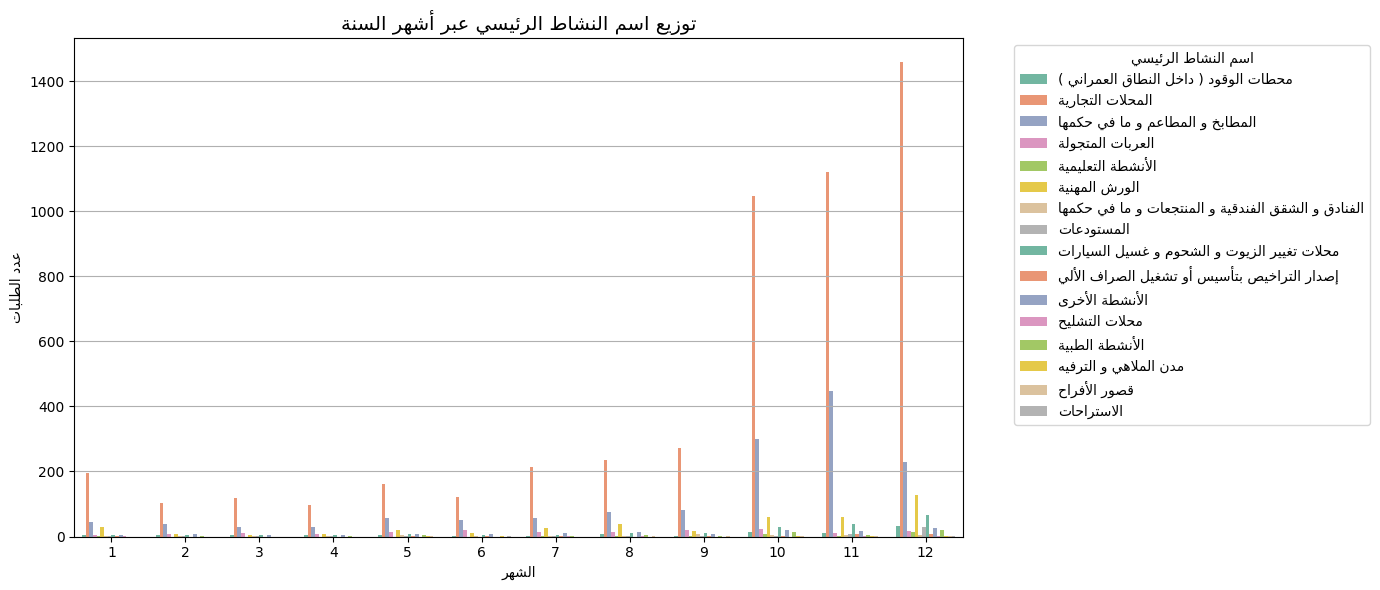

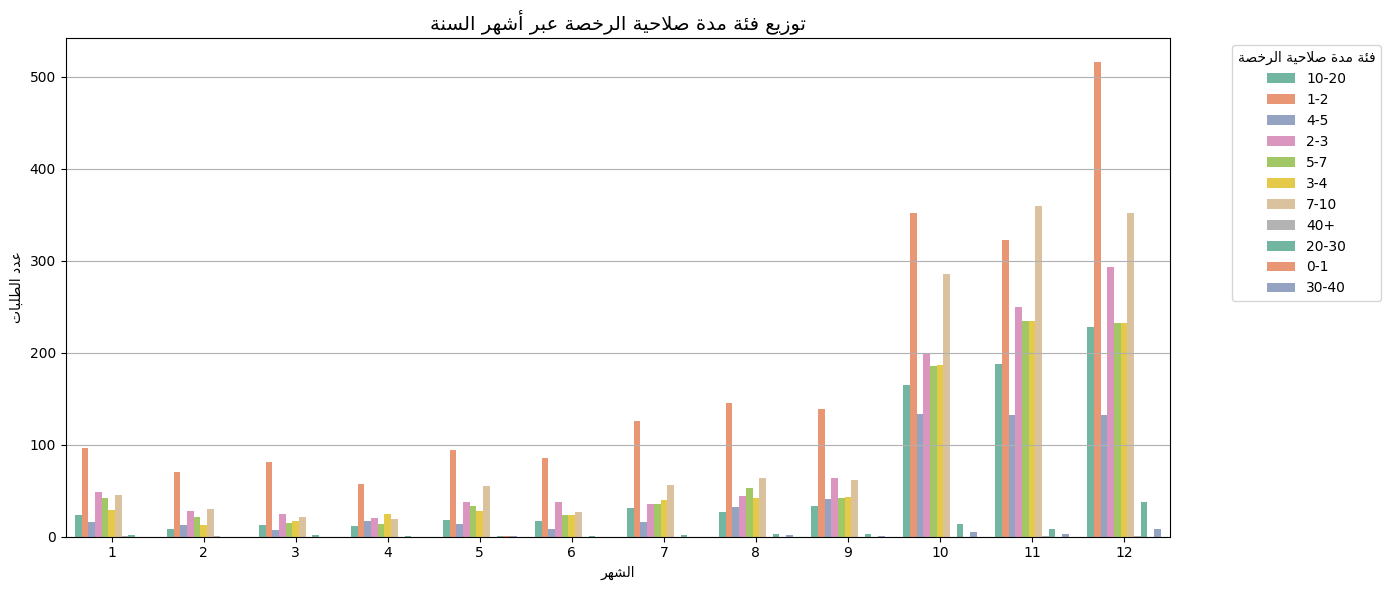

In [47]:

# Optional: limit number of categories per column to show (to avoid clutter)
# top_n = 5

for col in collection:
    categories = dataframe[col].value_counts().index
    df_filtered = dataframe[dataframe[col].isin(categories)].copy()

    df_filtered['category_reshaped'] = df_filtered[col].astype(str).apply(reshape_arabic)

    # Plot
    plt.figure(figsize=(14, 6))
    sns.countplot(
        data=df_filtered,
        x='شهر الطلب',
        hue='category_reshaped',
        palette='Set2'
    )

    plt.title(reshape_arabic(f'توزيع {col} عبر أشهر السنة'), fontsize=14)
    plt.xlabel(reshape_arabic('الشهر'))
    plt.ylabel(reshape_arabic('عدد الطلبات'))
    plt.legend(title=reshape_arabic(col), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


## 3. بناء النماذج التنبؤية
بعد الانتهاء من تحليل البيانات الزمنية وفهم الأنماط الموسمية، ننتقل الآن إلى بناء نموذج تنبؤ زمني متعدد الأبعاد، يهدف إلى توقّع حجم الطلب على الرخص التجارية شهريًا وأسبوعيًا، بالإضافة إلى التنبؤ بأنواع الطلبات والأنشطة التجارية المحتملة، وذلك لتقديم توصيات تنبؤية تساعد في تحسين توقيت التقديم وتقليل أوقات الانتظار.

In [48]:
dataframe.columns

Index(['البلدية', 'نوع الطلب', 'اسم النشاط الرئيسي', 'فئة مدة صلاحية الرخصة',
       'تاريخ الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب',
       'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

In [49]:
dataframe.sample()

,البلدية,نوع الطلب,اسم النشاط الرئيسي,فئة مدة صلاحية الرخصة,تاريخ الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
5760,بلدية جنوب سكاكا - قارا,تعديل رخصة تجارية,المطابخ و المطاعم و ما في حكمها,5-7,2024-10-28,2024,10,44,28,الإثنين,ﻦﻴﻨﺛﻹﺍ


In [50]:
columns_needed

['البلدية',
 'نوع الطلب',
 'اسم النشاط الرئيسي',
 'فئة مدة صلاحية الرخصة',
 'تاريخ الطلب',
 'سنة الطلب',
 'شهر الطلب',
 'أسبوع الطلب',
 'يوم الطلب',
 'يوم الأسبوع']

In [51]:
dataframe[dataframe.columns[:-1]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7799 entries, 0 to 7822
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   البلدية                7799 non-null   object        
 1   نوع الطلب              7799 non-null   object        
 2   اسم النشاط الرئيسي     7799 non-null   object        
 3   فئة مدة صلاحية الرخصة  7799 non-null   object        
 4   تاريخ الطلب            7799 non-null   datetime64[ns]
 5   سنة الطلب              7799 non-null   int32         
 6   شهر الطلب              7799 non-null   int32         
 7   أسبوع الطلب            7799 non-null   UInt32        
 8   يوم الطلب              7799 non-null   int32         
 9   يوم الأسبوع            7799 non-null   object        
dtypes: UInt32(1), datetime64[ns](1), int32(3), object(5)
memory usage: 556.0+ KB


In [52]:
def encode_and_save_encoders(df, columns, encoder_path="label_encoders.pkl"):
    """
    Encodes categorical columns using LabelEncoder and saves the encoders.
    
    Parameters:
        df: DataFrame to encode
        columns: List of column names to encode
        encoder_path: Path to save the encoder dictionary
    
    Returns:
        Encoded DataFrame
    """
    encoders = {}
    
    for col in columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            encoders[col] = le  # Save encoder for later use
    
    # Save all encoders to disk
    joblib.dump(encoders, encoder_path)
    print(f"✅ Encoders saved to {encoder_path}")
    
    return df


In [53]:
dataframe = encode_and_save_encoders(dataframe, columns_needed)

dataframe.sample()

✅ Encoders saved to label_encoders.pkl


C:\Users\USER\AppData\Local\Temp\ipykernel_5884\1550318294.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_5884\1550318294.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\USER\AppData\Local\Temp\ipykernel_5884\1550318294.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,البلدية,نوع الطلب,اسم النشاط الرئيسي,فئة مدة صلاحية الرخصة,تاريخ الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
3057,4,5,7,1,2024-12-16,2024,12,51,16,2,ﻦﻴﻨﺛﻹﺍ


### 3.1 نموذج التنبؤ الزمني لحجم الطلب *الشهري*

In [54]:
def train_prophet_with_accuracy(df):
    # Prepare daily data
    daily = df.groupby('تاريخ الطلب').size().reset_index(name='y')
    daily.columns = ['ds', 'y']
    daily['ds'] = pd.to_datetime(daily['ds'])

    split_index = int(len(daily) * 0.5)
    train = daily.iloc[:split_index]
    test = daily.iloc[split_index:]
    
    # print("Variance in y:", daily['y'].var())

    # Fit the model
    model = Prophet()
    model.fit(train)

    # Make future dataframe and forecast
    future = test[['ds']].copy()
    forecast = model.predict(future)

    # Merge actual vs predicted
    forecasted = forecast[['ds', 'yhat']].copy()
    merged = test.merge(forecasted, on='ds')

    plt.plot(merged['ds'], merged['y'], label='Actual')
    plt.plot(merged['ds'], merged['yhat'], label='Forecast')
    plt.legend()
    plt.title('Actual vs Forecast')
    plt.show()
    
    # Calculate metrics
    mae = mean_absolute_error(merged['y'], merged['yhat'])
    rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
    r2 = r2_score(merged['y'], merged['yhat'])
    print("Model performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")
    return model


13:34:23 - cmdstanpy - INFO - Chain [1] start processing
13:34:23 - cmdstanpy - INFO - Chain [1] done processing


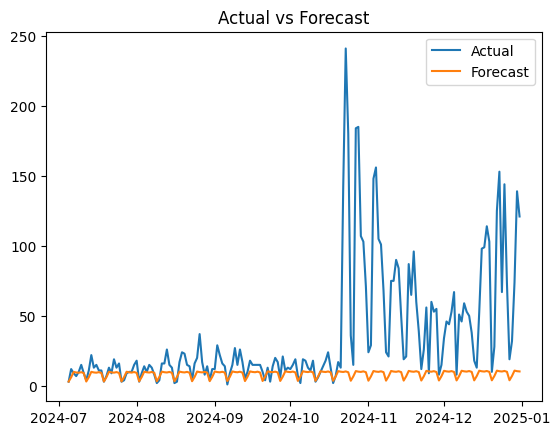

Model performance:
MAE: 27.48
RMSE: 49.90
R2: -0.36


In [55]:
prophet_model = train_prophet_with_accuracy(dataframe)

In [56]:
def train_prophet_full(df, forecast_days=90, evaluate=False):
    """
    Train Prophet on full dataset and forecast into future.
    If `evaluate=True`, it compares with actual future values (if available).
    """
    # Prepare daily data
    daily = df.groupby('تاريخ الطلب').size().reset_index(name='y')
    daily.columns = ['ds', 'y']
    daily['ds'] = pd.to_datetime(daily['ds'])

    # Train on full dataset
    model = Prophet()
    model.fit(daily)

    # Forecast future
    future = model.make_future_dataframe(periods=forecast_days, freq='D')
    forecast = model.predict(future)

    # Plot forecast
    plt.figure(figsize=(10, 5))
    plt.plot(daily['ds'], daily['y'], label='Actual')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.axvline(daily['ds'].max(), color='red', linestyle='--', label='Forecast Start')
    plt.legend()
    plt.title('Forecast for Future Demand')
    plt.show()

    # Optional: Evaluate if future data exists
    if evaluate:
        test = daily[daily['ds'] > daily['ds'].max() - pd.Timedelta(days=forecast_days)]
        forecasted = forecast[['ds', 'yhat']].copy()
        merged = test.merge(forecasted, on='ds')
        if not merged.empty:
            mae = mean_absolute_error(merged['y'], merged['yhat'])
            rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
            r2 = r2_score(merged['y'], merged['yhat'])
            print("Evaluation on Recent Data:")
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"R²: {r2:.2f}")
        else:
            print("No overlapping dates to evaluate against.")
    
    return model, forecast


13:34:23 - cmdstanpy - INFO - Chain [1] start processing
13:34:23 - cmdstanpy - INFO - Chain [1] done processing


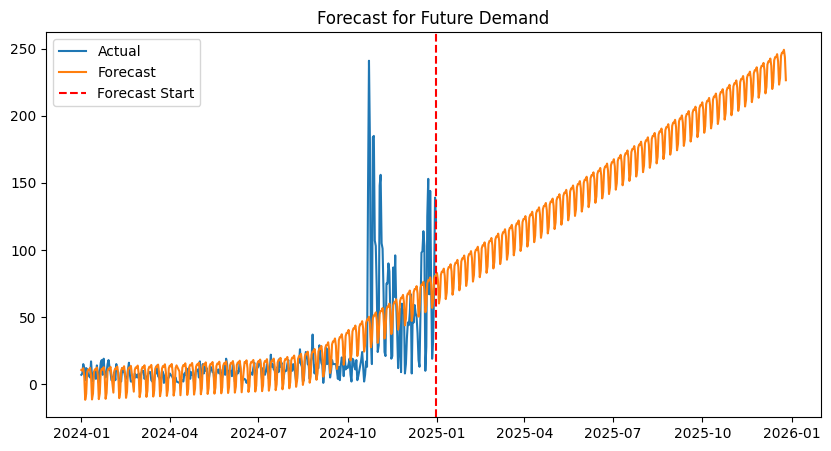

Evaluation on Recent Data:
MAE: 13.71
RMSE: 24.44
R²: 0.48


In [57]:
model, forecast = train_prophet_full(df, forecast_days=360, evaluate=True)


### 3.2 التنبؤ بالأنواع

In [58]:
dataframe

,البلدية,نوع الطلب,اسم النشاط الرئيسي,فئة مدة صلاحية الرخصة,تاريخ الطلب,سنة الطلب,شهر الطلب,أسبوع الطلب,يوم الطلب,يوم الأسبوع,يوم الأسبوع (عرض)
0,7,5,1,4,2024-12-22,2024,12,51,22,0,ﺪﺣﻷﺍ
1,11,0,7,1,2024-09-14,2024,9,37,14,6,ﺖﺒﺴﻟﺍ
2,1,0,7,1,2024-05-21,2024,5,21,21,3,ﺀﺎﺛﻼﺜﻟﺍ
3,7,5,7,10,2024-12-09,2024,12,50,9,2,ﻦﻴﻨﺛﻹﺍ
4,12,7,9,1,2024-11-06,2024,11,45,6,1,ﺀﺎﻌﺑﺭﻷﺍ
...,...,...,...,...,...,...,...,...,...,...,...
7818,4,0,5,1,2024-03-30,2024,3,13,30,6,ﺖﺒﺴﻟﺍ
7819,9,5,14,3,2024-12-22,2024,12,51,22,0,ﺪﺣﻷﺍ
7820,1,3,9,7,2024-05-09,2024,5,19,9,5,ﺲﻴﻤﺨﻟﺍ
7821,11,5,7,4,2024-11-19,2024,11,47,19,3,ﺀﺎﺛﻼﺜﻟﺍ


In [59]:
def train_classifiers(df):
    X = df[['البلدية', 'فئة مدة صلاحية الرخصة',
            'شهر الطلب', 'أسبوع الطلب','يوم الطلب' ]]
    y_type = df['نوع الطلب']
    y_activity = df['اسم النشاط الرئيسي']
    
    model_type = RandomForestClassifier()
    model_type.fit(X, y_type)
    
    model_activity = RandomForestClassifier()
    model_activity.fit(X, y_activity)
    
    print("Model performance")
    print(model_type.score(X, y_type), model_activity.score(X, y_activity))
    return model_type, model_activity


In [60]:
train_classifiers(dataframe)

Model performance
0.8789588408770355 0.8262597768944736


(RandomForestClassifier(), RandomForestClassifier())

In [61]:
def train_classifiers(df):
    # Features and targets
    X = df[['البلدية', 'فئة مدة صلاحية الرخصة',
            'شهر الطلب', 'أسبوع الطلب','يوم الطلب' ]]
    
    y_type = df['نوع الطلب']
    y_activity = df['اسم النشاط الرئيسي']

    # Split data (80% train, 20% test)
    X_train, X_test, y_type_train, y_type_test = train_test_split(X, y_type, test_size=0.1, random_state=42)
    _, _, y_activity_train, y_activity_test = train_test_split(X, y_activity, test_size=0.1, random_state=42)

    # Train models
    model_type = RandomForestClassifier()
    model_type.fit(X_train, y_type_train)
    
    model_activity = RandomForestClassifier()
    model_activity.fit(X_train, y_activity_train)

    # Predict
    y_type_pred = model_type.predict(X_test)
    y_activity_pred = model_activity.predict(X_test)

    # Evaluate
    print("Model performance:")
    print("Model performance")
    print(model_type.score(X, y_type), model_activity.score(X, y_activity))
    print("نوع الطلب accuracy:", accuracy_score(y_type_test, y_type_pred))
    print("اسم النشاط الرئيسي accuracy:", accuracy_score(y_activity_test, y_activity_pred))

    # Optional: Print detailed report
    print("\nClassification Report for نوع الطلب:")
    print(classification_report(y_type_test, y_type_pred))

    print("\nClassification Report for اسم النشاط الرئيسي:")
    print(classification_report(y_activity_test, y_activity_pred))

    # Plot Confusion Matrix for نوع الطلب
    plt.figure(figsize=(10, 5))
    ConfusionMatrixDisplay.from_estimator(model_type, X_test, y_type_test, xticks_rotation=45)
    plt.title("Confusion Matrix - نوع الطلب")
    plt.show()

    # Plot Confusion Matrix for اسم النشاط الرئيسي
    plt.figure(figsize=(10, 5))
    ConfusionMatrixDisplay.from_estimator(model_activity, X_test, y_activity_test, xticks_rotation=45)
    plt.title("Confusion Matrix - اسم النشاط الرئيسي")
    plt.show()

    return model_type, model_activity


Model performance:
Model performance
0.8586998333119631 0.806898320297474
نوع الطلب accuracy: 0.617948717948718
اسم النشاط الرئيسي accuracy: 0.5987179487179487

Classification Report for نوع الطلب:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44        89
           1       0.35      0.25      0.29        24
           2       0.33      0.28      0.31        95
           3       0.51      0.47      0.49       164
           4       0.00      0.00      0.00         6
           5       0.77      0.87      0.81       383
           7       0.14      0.05      0.08        19

    accuracy                           0.62       780
   macro avg       0.36      0.34      0.35       780
weighted avg       0.59      0.62      0.60       780


Classification Report for اسم النشاط الرئيسي:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00      

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

<Figure size 1000x500 with 0 Axes>

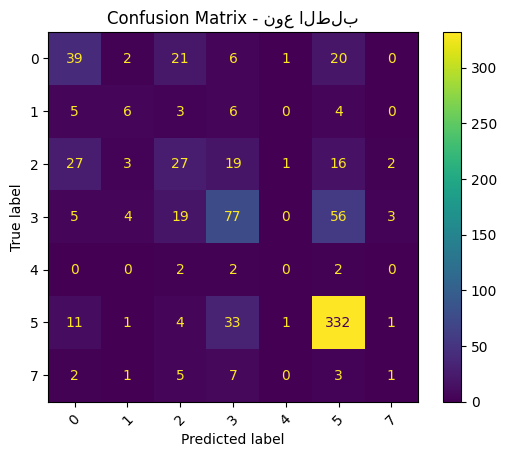

<Figure size 1000x500 with 0 Axes>

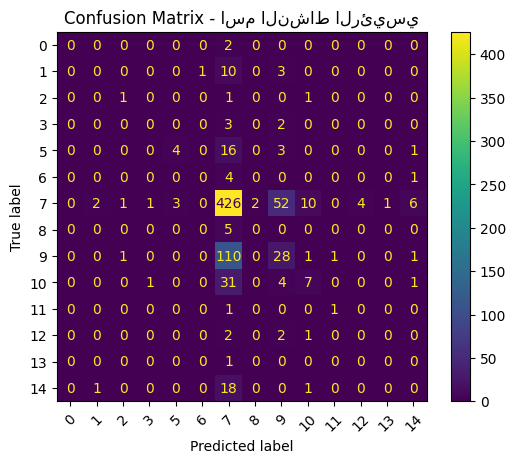

In [62]:
clf_type, clf_activity = train_classifiers(dataframe)


In [63]:
def train_classifiers_crossval(df):
    X = df[['البلدية','فئة مدة صلاحية الرخصة',
            'شهر الطلب', 'أسبوع الطلب','يوم الطلب' ]]
    
    y_type = df['نوع الطلب']
    y_activity = df['اسم النشاط الرئيسي']

    model_type = RandomForestClassifier()
    model_activity = RandomForestClassifier()

    # Cross-validation scores
    scores_type = cross_val_score(model_type, X, y_type, cv=5)
    scores_activity = cross_val_score(model_activity, X, y_activity, cv=5)
    
    # Print results
    print("Cross-Validated Accuracy (نوع الطلب):")
    print(f"Scores: {scores_type}")
    print(f"Mean Accuracy: {np.mean(scores_type):.3f}")

    print("\nCross-Validated Accuracy (اسم النشاط الرئيسي):")
    print(f"Scores: {scores_activity}")
    print(f"Mean Accuracy: {np.mean(scores_activity):.3f}")

    model_type.fit(X, y_type)
    model_activity.fit(X, y_activity)
    
    print("Model performance")
    print(model_type.score(X, y_type), model_activity.score(X, y_activity))
    return model_type, model_activity


In [64]:
type_cvModel,act_cvModel = train_classifiers_crossval(dataframe)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validated Accuracy (نوع الطلب):
Scores: [0.64166667 0.64615385 0.63076923 0.6474359  0.63822963]
Mean Accuracy: 0.641

Cross-Validated Accuracy (اسم النشاط الرئيسي):
Scores: [0.59551282 0.59423077 0.60705128 0.6        0.59846055]
Mean Accuracy: 0.599
Model performance
0.8787023977433004 0.8262597768944736


#### 3.2.1 automl

In [65]:
!pip install flaml


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
dataframe.columns

Index(['البلدية', 'نوع الطلب', 'اسم النشاط الرئيسي', 'فئة مدة صلاحية الرخصة',
       'تاريخ الطلب', 'سنة الطلب', 'شهر الطلب', 'أسبوع الطلب', 'يوم الطلب',
       'يوم الأسبوع', 'يوم الأسبوع (عرض)'],
      dtype='object')

In [67]:
from flaml import AutoML

def train_automl_for_both_targets(df):
    X = df[['البلدية', 'فئة مدة صلاحية الرخصة',
            'شهر الطلب', 'أسبوع الطلب','يوم الطلب' ]]
    y_type = df['نوع الطلب']
    y_activity = df['اسم النشاط الرئيسي']

    automl_type = AutoML(task="classification", time_budget=300)
    automl_type.fit(X, y_type)
    print("Best estimator type model:", automl_type.best_estimator)
    print("Best config type model:", automl_type.best_config)
    print("Best validation loss (score) type model:", automl_type.best_loss)

    automl_activity = AutoML(task="classification", time_budget=300)
    automl_activity.fit(X, y_activity)
    print("Best estimator activity model:", automl_activity.best_estimator)
    print("Best config activity model:", automl_activity.best_config)
    print("Best validation loss (score) activity model:", automl_activity.best_loss)

    return automl_type, automl_activity


In [68]:
act_model, type_model = train_automl_for_both_targets(dataframe)

[flaml.automl.logger: 08-12 13:34:34] {1728} INFO - task = classification
[flaml.automl.logger: 08-12 13:34:34] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 08-12 13:34:34] {1838} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 08-12 13:34:34] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 08-12 13:34:34] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-12 13:34:34] {2393} INFO - Estimated sufficient time budget=1836s. Estimated necessary time budget=45s.
[flaml.automl.logger: 08-12 13:34:34] {2442} INFO -  at 0.2s,	estimator lgbm's best error=1.1476,	best estimator lgbm's best error=1.1476
[flaml.automl.logger: 08-12 13:34:34] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-12 13:34:34] {2442} INFO -  at 0.4s,	estimator lgbm's best error=1.1476,	best estimator lgbm's best error=1.1476
[flaml.automl.log

##### 3.2.1 تقييم النموذج

In [69]:
print("Best estimator activity model:", act_model.best_estimator)
print("Best config activity model:", act_model.best_config)
print("Best validation loss (score) activity model:", act_model.best_loss)

Best estimator activity model: xgb_limitdepth
Best config activity model: {'n_estimators': 96, 'max_depth': 6, 'min_child_weight': np.float64(0.7574441426199574), 'learning_rate': np.float64(0.08704392861846535), 'subsample': np.float64(0.9517459550978583), 'colsample_bylevel': np.float64(0.7015879783609756), 'colsample_bytree': np.float64(0.7987750653024748), 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(0.06829710852480617)}
Best validation loss (score) activity model: 0.8942241472994942


In [70]:
print("Best estimator activity model:", type_model.best_estimator)
print("Best config activity model:", type_model.best_config)
print("Best validation loss (score) activity model:", type_model.best_loss)

Best estimator activity model: lgbm
Best config activity model: {'n_estimators': 16, 'num_leaves': 15, 'min_child_samples': 16, 'learning_rate': np.float64(0.2626308856233307), 'log_max_bin': 8, 'colsample_bytree': np.float64(0.799391891876062), 'reg_alpha': 0.0009765625, 'reg_lambda': np.float64(1.9263672312620643)}
Best validation loss (score) activity model: 1.1165320199864224


## 4. بناء نظام التوقعات

In [71]:
# Load saved encoders
encoders = joblib.load("label_encoders.pkl")

def encode_input_for_prediction(input_dict, encoders):
    encoded_input = {}
    for col, val in input_dict.items():
        if col in encoders:
            le = encoders[col]
            try:
                encoded_val = le.transform([val])[0]
            except ValueError:
                raise ValueError(f"❌ Value '{val}' not seen during training for column '{col}'")
            encoded_input[col] = encoded_val
        else:
            encoded_input[col] = val  
    return pd.DataFrame([encoded_input])

In [91]:
def advise_user(future_date, prophet_model, clf_type, clf_activity,
                municipality, validity_category,
                threshold=25):
    
    # Step 1: Date features
    date = pd.to_datetime(future_date)
    month = date.month
    week = date.isocalendar().week
    day = date.day

    # Step 2: Forecast future demand
    last_train_date = prophet_model.history['ds'].max()
    days_needed = (date - last_train_date).days + 30
    if days_needed < 0:
        days_needed *= -1

    future_df = prophet_model.make_future_dataframe(periods=days_needed, freq='D')
    forecast = prophet_model.predict(future_df)
    predicted_row = forecast[forecast['ds'] == date]

    if predicted_row.empty:
        return "! No forecast data available for this date."

    predicted_demand = predicted_row['yhat'].values[0]

    # Step 3: Raw user input
    raw_input = {
        'البلدية': municipality,
        'فئة مدة صلاحية الرخصة': validity_category,
        'شهر الطلب': month,
        'أسبوع الطلب': week,
        'يوم الطلب': day
    }

    # Step 4: Encode
    X_encoded = encode_input_for_prediction(raw_input, encoders)

    # Step 5: Predict
   # Get encoded predictions
    encoded_type = clf_type.predict(X_encoded)[0]
    encoded_activity = clf_activity.predict(X_encoded)[0]

# Decode predictions using saved encoders
    predicted_type = encoders['نوع الطلب'].inverse_transform([encoded_type])[0]
    predicted_activity = encoders['اسم النشاط الرئيسي'].inverse_transform([encoded_activity])[0]


    # Step 6: Advisory
    if predicted_demand > threshold:
        return f"""
{date.strftime('%d %B %Y')} is expected to be busy. It's recommended to delay submitting your request to avoid delays.
Most common request type: {predicted_type}
Dominant activities: {predicted_activity}
        """.strip()
    else:
        return f"""
{date.strftime('%d %B %Y')} is a suitable time to submit your request.
Expected request type: {predicted_type}
Common activities: {predicted_activity}
        """.strip()


In [92]:
input_columns = [
    'البلدية',
    'فئة مدة صلاحية الرخصة'
]


In [97]:
sample_row = df[input_columns].sample(1).iloc[0]


In [98]:
sample_input = sample_row.to_dict()
sample_input

{'البلدية': 'بلدية وسط سكاكا', 'فئة مدة صلاحية الرخصة': '3-4'}

In [99]:
advise_user(
    future_date="2024-08-25",
    prophet_model=prophet_model,
    clf_type=type_cvModel,
    clf_activity=act_cvModel,
    municipality=sample_input['البلدية'],
    validity_category=sample_input['فئة مدة صلاحية الرخصة']
)


'25 August 2024 is a suitable time to submit your request.\nExpected request type: إصدار رخصة تجارية\nCommon activities: المحلات التجارية'

## 5. حفظ النماذج

In [77]:
# Save
with open('prophet_model.pkl', 'wb') as f:
    joblib.dump(prophet_model, f)

# Load
with open('prophet_model.pkl', 'rb') as f:
    loaded_prophet_model = joblib.load(f)


In [78]:
# Save
with open('type_cvModel.pkl', 'wb') as f:
    joblib.dump(type_cvModel, f)

with open('act_cvModel.pkl', 'wb') as f:
    joblib.dump(act_cvModel, f)

# Load
with open('type_cvModel.pkl', 'rb') as f:
    type_cvModel = joblib.load(f)

with open('act_cvModel.pkl', 'rb') as f:
    act_cvModel = joblib.load(f)
